# Introduction

The objective of this project, "Natural Language Processing with Disaster Tweets," is to develop a machine learning model that can predict whether a given tweet is about a real disaster or not. By leveraging Natural Language Processing (NLP) techniques, we aim to analyze the textual content of tweets and classify them accordingly. This project is hosted on Kaggle, providing a dataset of tweets labeled as either related to real disasters or not, which will be used to train and evaluate our model.

**Brief Introduction to NLP**

Natural Language Processing (NLP) is a subfield of artificial intelligence (AI) that focuses on the interaction between computers and human language. It involves the development of algorithms and models that enable machines to understand, interpret, and generate human language in a way that is both meaningful and useful.

Key tasks in NLP include:

- Text Classification: Assigning predefined categories to text documents. In this project, we will classify tweets as either related to real disasters or not.
- Sentiment Analysis: Determining the sentiment or emotional tone of a piece of text.
- Named Entity Recognition (NER): Identifying and classifying entities such as names, dates, and locations within text.
- Machine Translation: Translating text from one language to another.
- Text Summarization: Producing a concise summary of a longer text document.
- Part-of-Speech Tagging: Identifying the grammatical parts of speech in a sentence.
By applying NLP techniques, we can transform unstructured text data into structured information that can be analyzed and used for various applications, including disaster response, sentiment analysis, and more.

In this project, we will explore various NLP techniques to preprocess the tweet data, extract meaningful features, and build a robust classification model. Our goal is to achieve high accuracy in predicting whether a tweet is about a real disaster.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import re

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

# sklearn
from sklearn.model_selection import train_test_split

# keras and tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Import and Exploratory Data Analysis

In [25]:
#Importing the data
df_test = pd.read_csv(r"test.csv")
df_train = pd.read_csv(r"train.csv")

In [26]:
#Exploring the Data Structure and Size
display(df_train.head())
df_train.shape


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)

In [27]:
display(df_test.head())
df_test.shape

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


(3263, 4)

We see that the training data has 7613 rows and five columns, whereas the test data has only 3263 rows and four columns. 

Here are brief descriptions of the columns:

1) id - A numeric index referring to the entry.
2) keyword - a one word description trying to encapsulate the tweet
3) location -the location from which the tweet was issued
4) text -the body of the tweet. This will be the source of our analysis
5) target (training set only) - binary classifier. Value of 1 if an actual disaster is referenced. If not, it gets a value of 0

## Exploratory Data Analysis
First, lets look at the distibution of the target variable

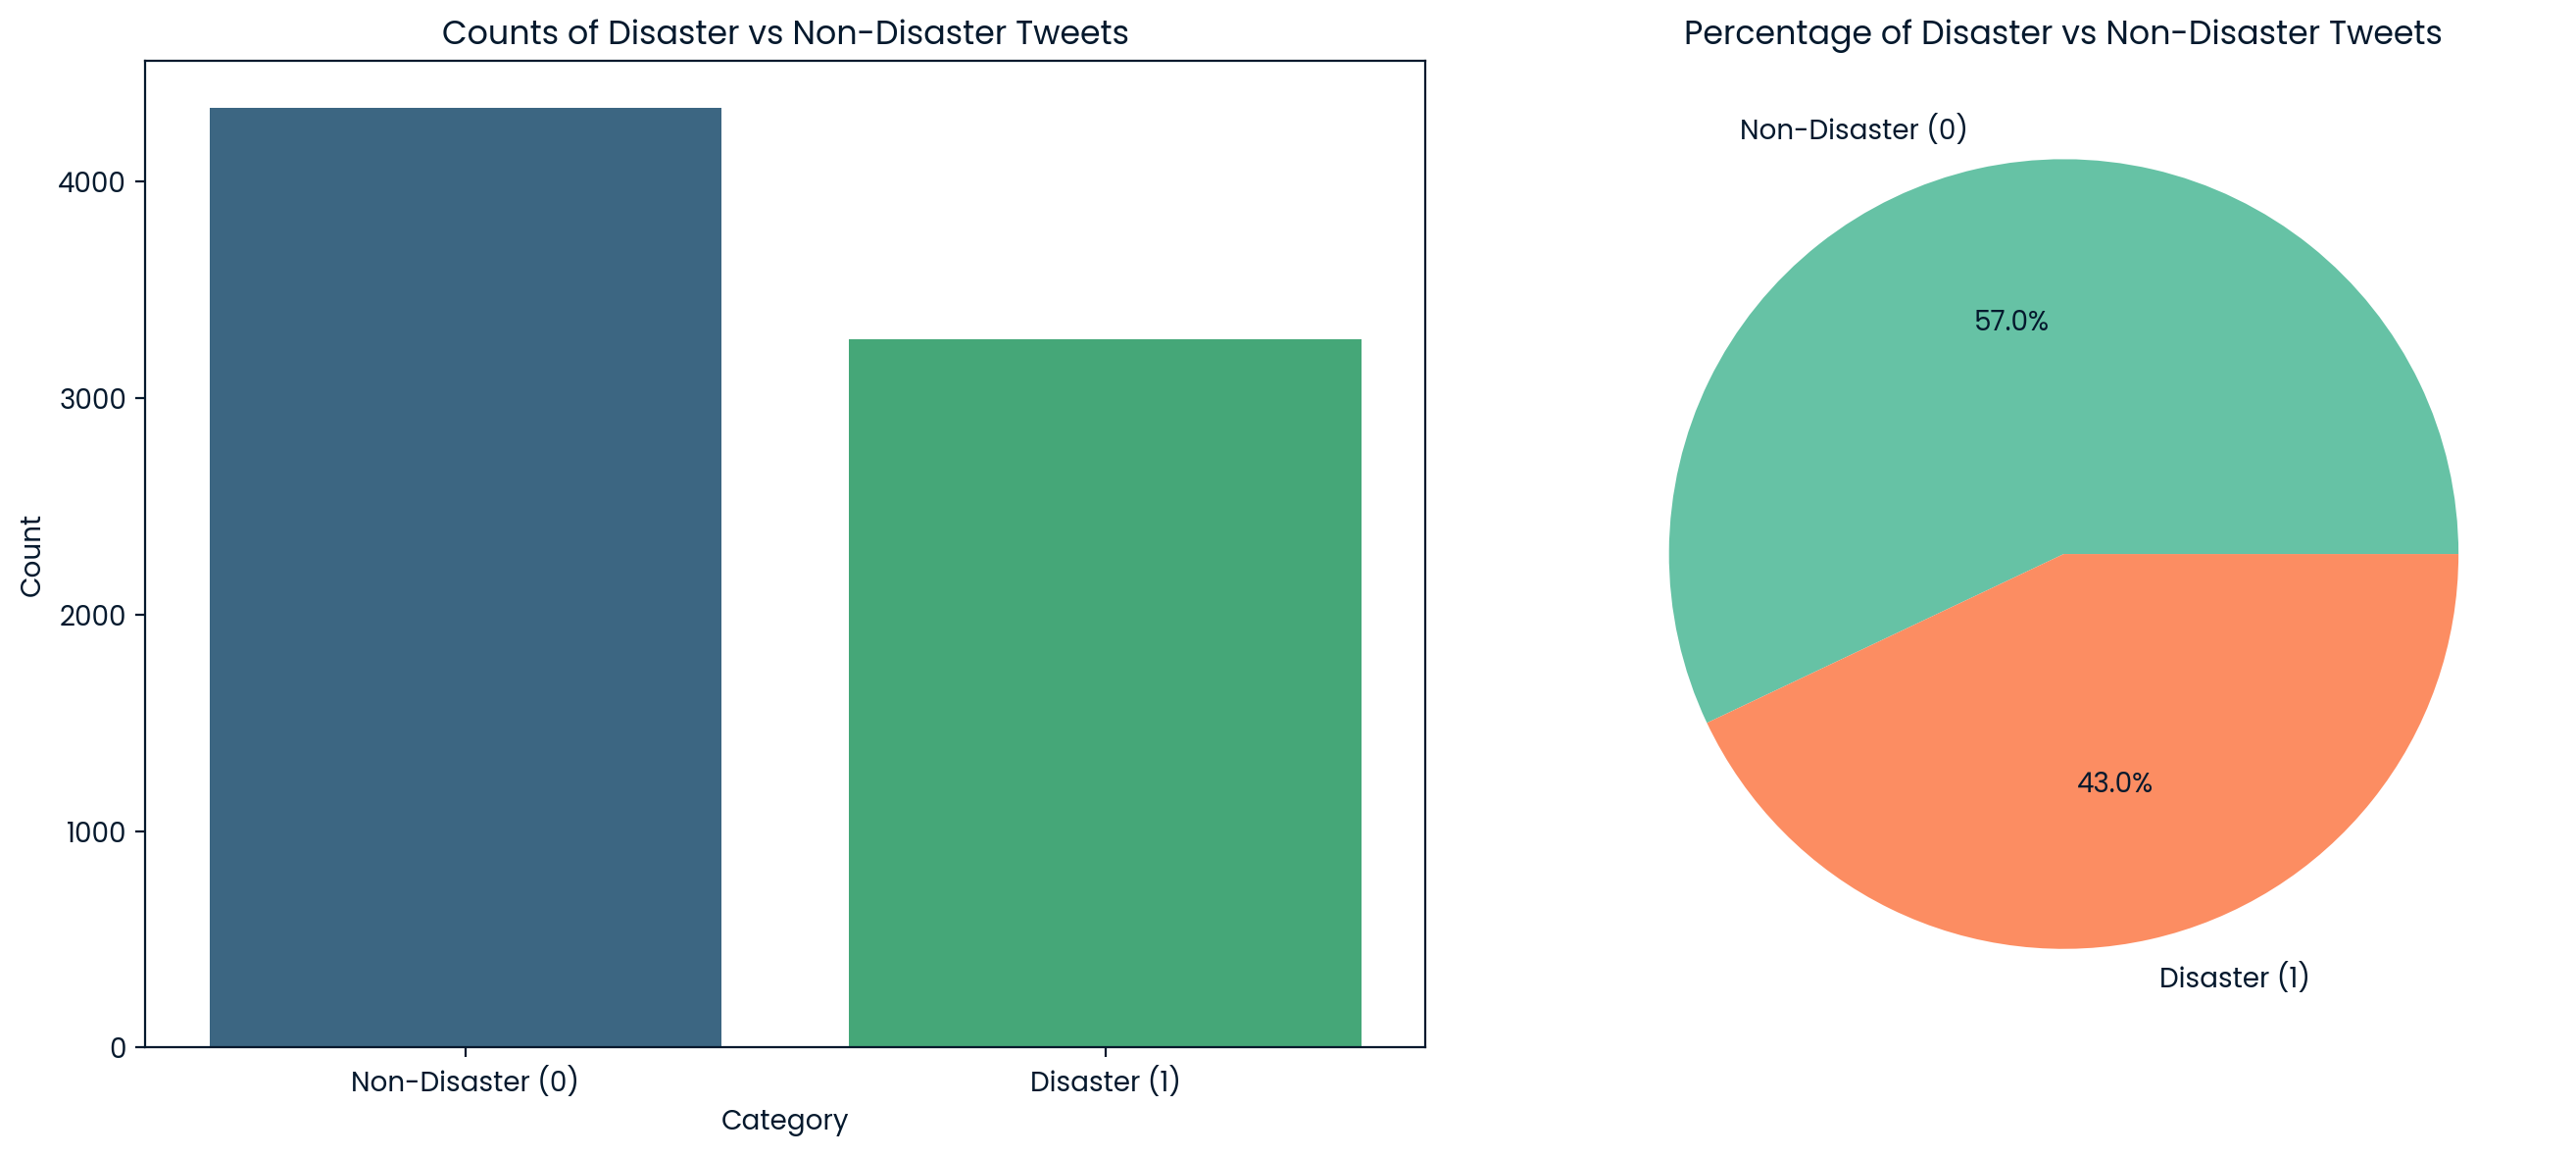

In [28]:
# Exploratory Data Analysis

# Count the occurrences of each class
counts = df_train['target'].value_counts()
percentages = df_train['target'].value_counts(normalize=True) * 100

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of counts
sns.barplot(x=counts.index, y=counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Counts of Disaster vs Non-Disaster Tweets')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Disaster (0)', 'Disaster (1)'])

# Pie chart of percentages
axes[1].pie(percentages, labels=['Non-Disaster (0)', 'Disaster (1)'], autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'])
axes[1].set_title('Percentage of Disaster vs Non-Disaster Tweets')

# Display the plots
plt.tight_layout()
plt.show()

Next, lets look at the most frequent keywords and locations in the test and train dataset. (We can't include all locations and keywords in the barcharts because there are too many)

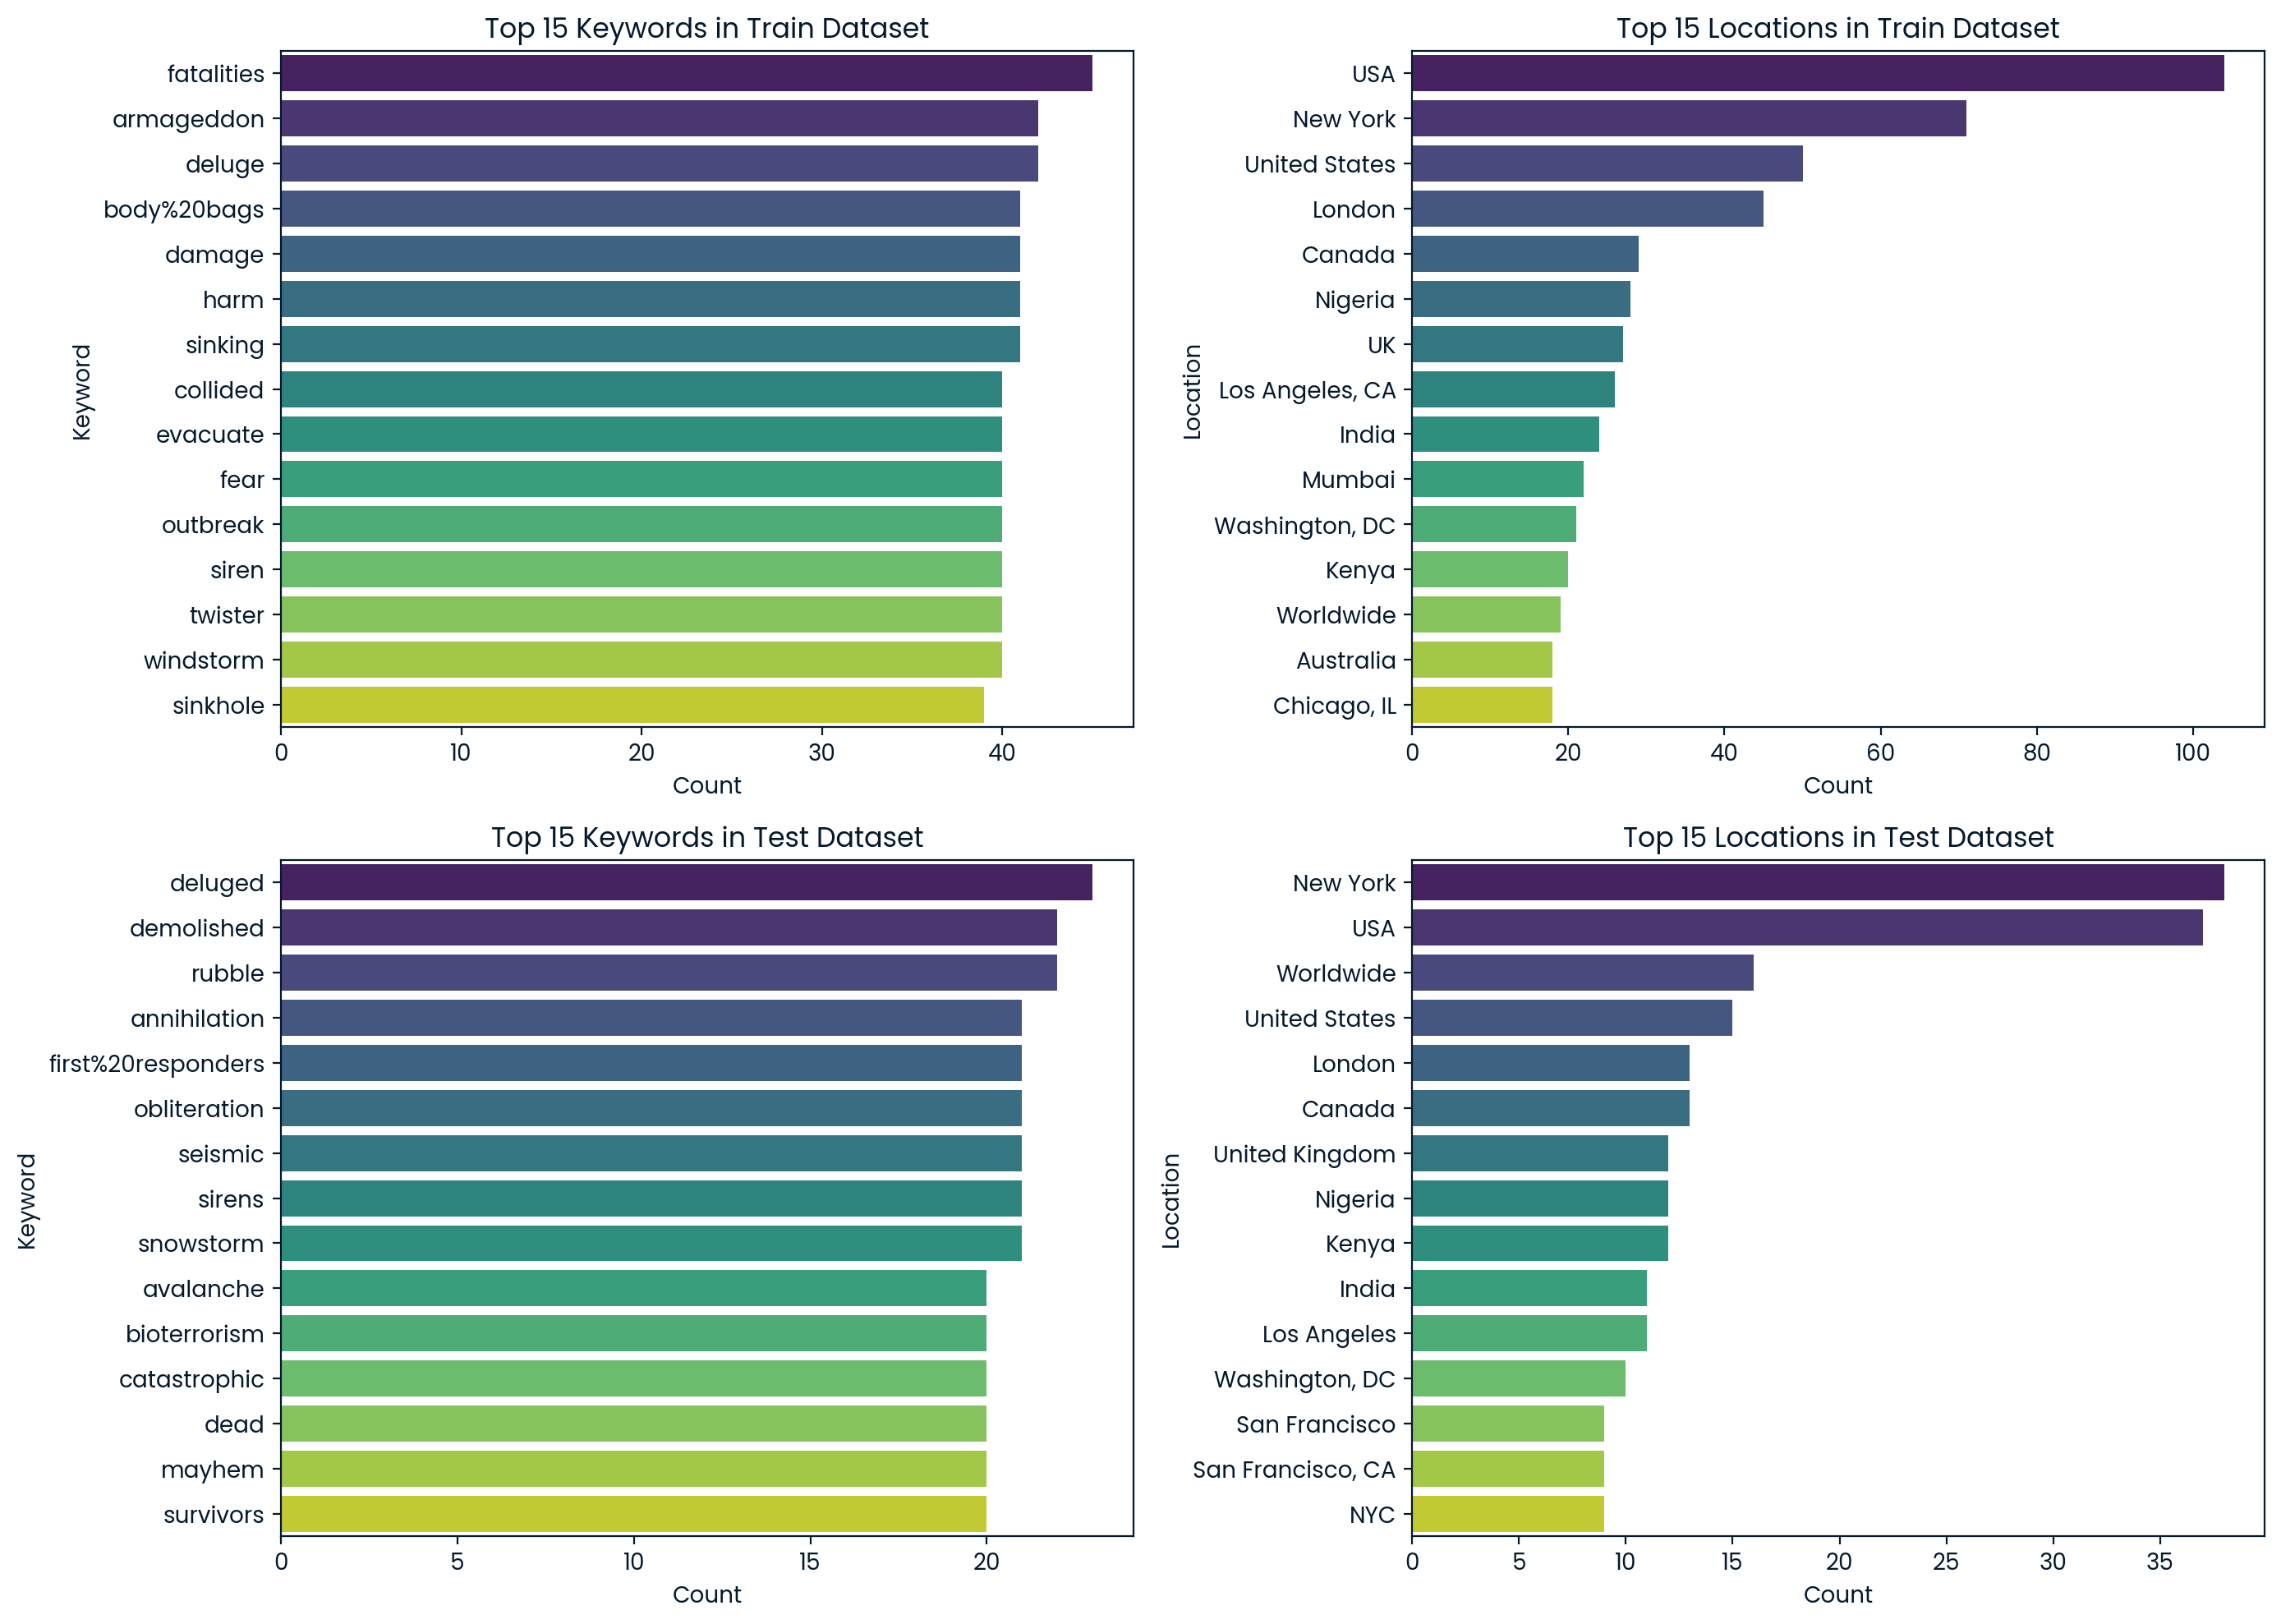

In [29]:
# Function to get top N most frequent values
def get_top_n(df, column, n=15):
    top_n = df[column].value_counts().nlargest(n).index
    return df[df[column].isin(top_n)]

# Filter the DataFrames to include only the top 15 most frequent keywords and locations
df_train_top_keywords = get_top_n(df_train, 'keyword')
df_train_top_locations = get_top_n(df_train, 'location')
df_test_top_keywords = get_top_n(df_test, 'keyword')
df_test_top_locations = get_top_n(df_test, 'location')

# Create a 2x2 grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot counts of top 15 keywords in df_train
sns.countplot(y='keyword', data=df_train_top_keywords, ax=axes[0, 0], order=df_train_top_keywords['keyword'].value_counts().index, palette='viridis')
axes[0, 0].set_title('Top 15 Keywords in Train Dataset')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Keyword')

# Plot counts of top 15 locations in df_train
sns.countplot(y='location', data=df_train_top_locations, ax=axes[0, 1], order=df_train_top_locations['location'].value_counts().index, palette='viridis')
axes[0, 1].set_title('Top 15 Locations in Train Dataset')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Location')

# Plot counts of top 15 keywords in df_test
sns.countplot(y='keyword', data=df_test_top_keywords, ax=axes[1, 0], order=df_test_top_keywords['keyword'].value_counts().index, palette='viridis')
axes[1, 0].set_title('Top 15 Keywords in Test Dataset')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Keyword')

# Plot counts of top 15 locations in df_test
sns.countplot(y='location', data=df_test_top_locations, ax=axes[1, 1], order=df_test_top_locations['location'].value_counts().index, palette='viridis')
axes[1, 1].set_title('Top 15 Locations in Test Dataset')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Location')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

Next, lets examine the word and character distribution among the tweets in the two datasets 

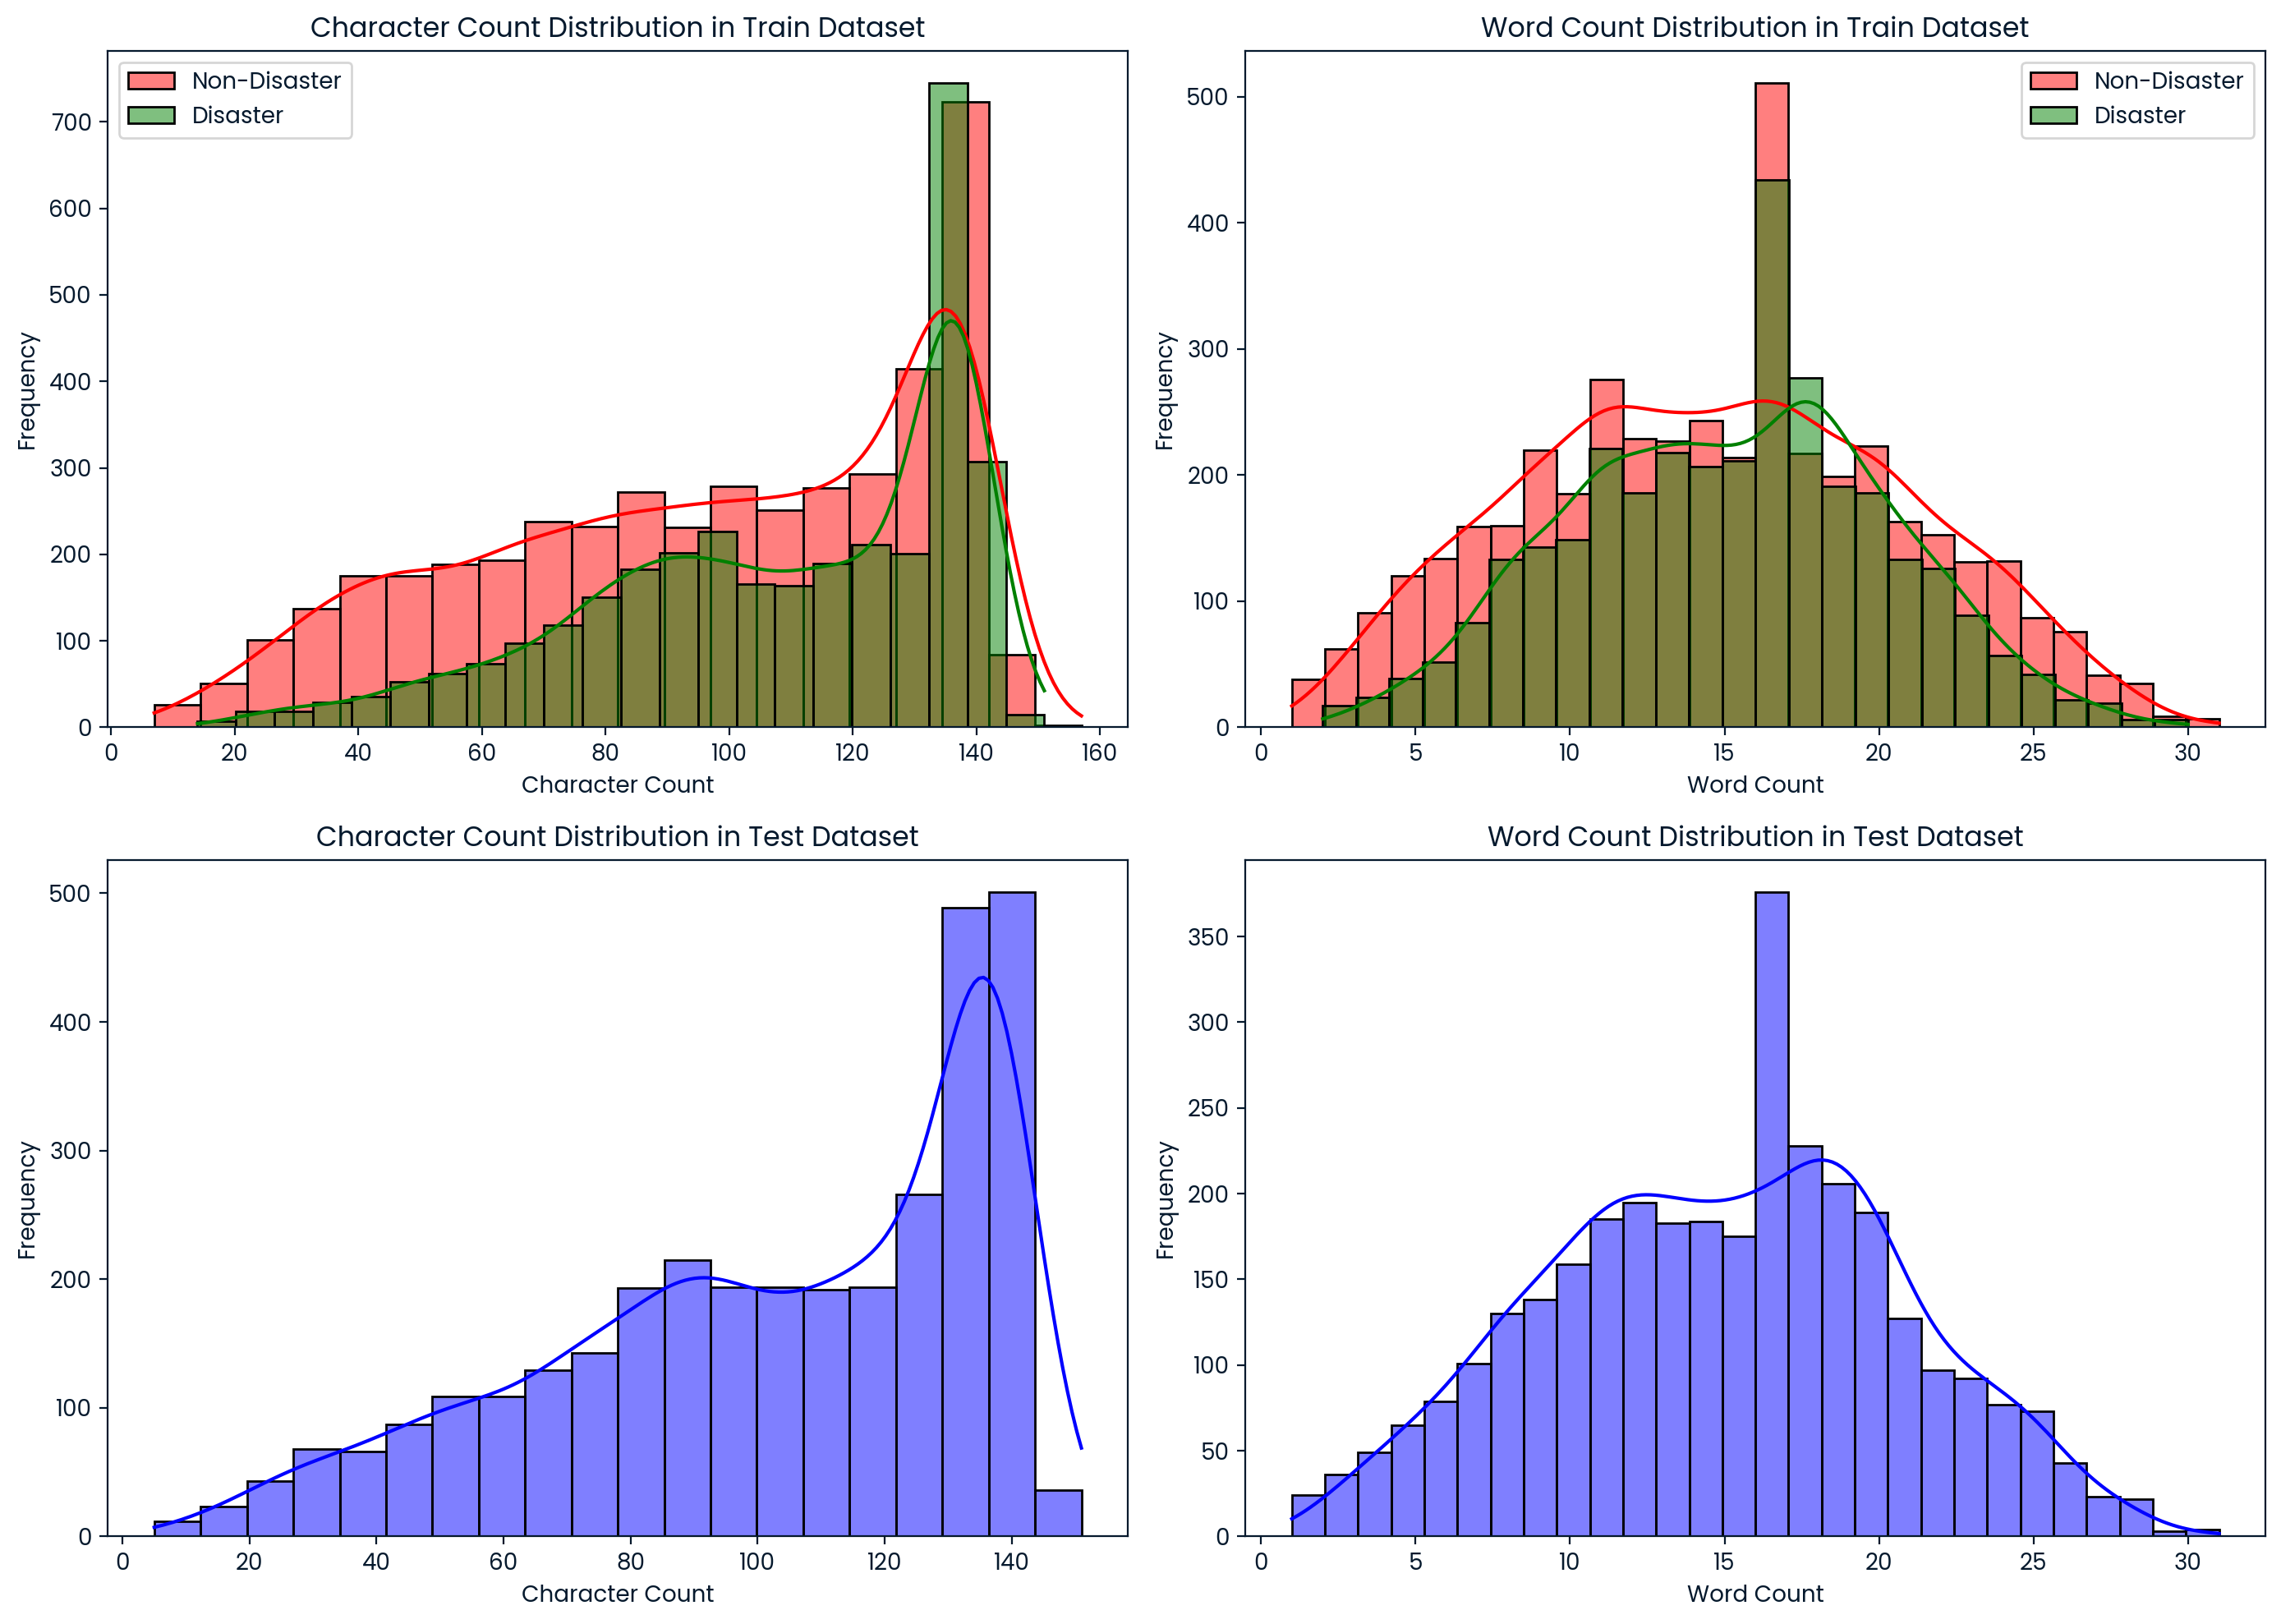

In [30]:
# Calculate character count and word count for each text
df_train['char_count'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
df_test['char_count'] = df_test['text'].apply(len)
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot character count distribution for df_train, split by target
sns.histplot(df_train[df_train['target'] == 0]['char_count'], kde=True, ax=axes[0, 0], color='red', label='Non-Disaster')
sns.histplot(df_train[df_train['target'] == 1]['char_count'], kde=True, ax=axes[0, 0], color='green', label='Disaster')
axes[0, 0].set_title('Character Count Distribution in Train Dataset')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Plot word count distribution for df_train, split by target
sns.histplot(df_train[df_train['target'] == 0]['word_count'], kde=True, ax=axes[0, 1], color='red', label='Non-Disaster')
sns.histplot(df_train[df_train['target'] == 1]['word_count'], kde=True, ax=axes[0, 1], color='green', label='Disaster')
axes[0, 1].set_title('Word Count Distribution in Train Dataset')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Plot character count distribution for df_test
sns.histplot(df_test['char_count'], kde=True, ax=axes[1, 0], color='blue')
axes[1, 0].set_title('Character Count Distribution in Test Dataset')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')

# Plot word count distribution for df_test
sns.histplot(df_test['word_count'], kde=True, ax=axes[1, 1], color='blue')
axes[1, 1].set_title('Word Count Distribution in Test Dataset')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

It is interesting that while word count appears somewhat gaussian, the charachter count is clearly left-skewed

## Data Cleaning
Having got a view of the distribution of the variables, lets clean the data. 
First, we will look for missing or duplicate values

In [31]:
# Check for duplicate values in the "text" column
duplicate_train = df_train['text'].duplicated().sum()
duplicate_test = df_test['text'].duplicated().sum()

# Check for missing values in both DataFrames
missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()

# Print the results
print(f"Number of duplicate texts in df_train: {duplicate_train}")
print(f"Number of duplicate texts in df_test: {duplicate_test}")
print("\nMissing values in df_train:")
print(missing_train)
print("\nMissing values in df_test:")
print(missing_test)

Number of duplicate texts in df_train: 110
Number of duplicate texts in df_test: 20

Missing values in df_train:
id               0
keyword         61
location      2533
text             0
target           0
char_count       0
word_count       0
dtype: int64

Missing values in df_test:
id               0
keyword         26
location      1105
text             0
char_count       0
word_count       0
dtype: int64


We see that there are many missing values in the keyword and location columns. We will drop those in any case, as the only column of relevance is the text column.

In [32]:
# Drop duplicate texts in both DataFrames
df_train_subset = df_train.drop_duplicates(subset='text')
df_test_subset = df_test.drop_duplicates(subset='text')

# Extract only the columns of interest
df_train_subset = df_train_subset[['text', 'target']]
df_test_subset = df_test_subset[['text']]

display(df_train_subset.head())
display(df_test_subset.head())

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


The next step in our cleaning is to remove the stopwords from the "text" column. 
Stopwords are common words that usually do not carry significant meaning. Examples of stopwords include "is", "and", "the", "in", etc. In exercises such as these, it is considered good practice to remove stop words for a couple reasons:

1) Noise Reduction - Stopwords add noise to the data, making it harder for the model to learn meaningful patterns. By removing them, we focus on the words that carry more significant information. This can improve model accuracy.

2) Dimensionality Reduction - Removing stopwords reduces the number of unique words (features) in the dataset, which can help in reducing the complexity of the model and improve computational efficiency.

In [33]:
# Download the stopwords from nltk
nltk.download('stopwords')
nltk.download('punkt')

# Define the stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from text
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Apply the function to the "text" column in both DataFrames
df_train_subset['text'] = df_train_subset['text'].apply(remove_stopwords)
df_test_subset['text'] = df_test_subset['text'].apply(remove_stopwords)

# Display the first few rows of the DataFrames to verify
display(df_train.head())
display(df_train_subset.head())
display(df_test.head())
display(df_test_subset.head())

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,keyword,location,text,target,char_count,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


,text,target
0,Deeds Reason # earthquake May ALLAH Forgive us,1
1,Forest fire near La Ronge Sask . Canada,1
2,residents asked 'shelter place ' notified offi...,1
3,"13,000 people receive # wildfires evacuation o...",1
4,got sent photo Ruby # Alaska smoke # wildfires...,1


,id,keyword,location,text,char_count,word_count
0,0,NaN,NaN,Just happened a terrible car crash,34,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,8


,text
0,happened terrible car crash
1,"Heard # earthquake different cities , stay saf..."
2,"forest fire spot pond , geese fleeing across s..."
3,Apocalypse lighting . # Spokane # wildfires
4,Typhoon Soudelor kills 28 China Taiwan


We can see that the stopwords have been successfully removed! Having completed the exploratory data analysis and cleaning, lets discuss our plan to create predictive models to predict if the text in the tweet is referencing an actual natural disaster or not. 

# Model Building
## Data Transformation Discussion
Before we can model the data, we first must transform the text into numerical data. One way to do this is the TF-IDF method. TF-IDF (Term Frequency-Inverse Document Frequency) is a common technique used in Natural Language Processing (NLP) to convert text data into numerical vectors while highlighting the importance of words in the text. The general idea of how it works is as follows:

TF (Term Frequency)-As the name implies, it refers to how many times a word appears in a document, divided by the number of words in the document. 
IDF (Inverse Document Frequency) - This measures how unique a word is across all the documents in the set. It is calculated by taking the log(total_#_documents/documents_containing_specific_word). This was used in the previous course's assignment when we classified news articles based on their word content.

TF-IDF has some advantages. It is simple to understand and implement, is computationally effecient and is interpretable. However, it is context ignorant and does not understand nuance. The classification task before us is all about nuance. We must distinguish between tweets that use words literally and tweets that use them metaphorically. Therefore, we will need a more sophisticated method. 

A better choice here is the RNN (Recurrent Neural Network). Here is a summary of how it works:

1) Sequential Data Processing: RNNs are designed to handle sequences of data, such as text, time series, or speech, by processing one element at a time.
2) Hidden State: They maintain a hidden state that captures information from previous elements in the sequence, allowing them to remember context..
3) Recurrent Connections: RNNs have connections that loop back on themselves, enabling information to be passed from one time step to the next.
4) State update: At each time step, the hidden state is updated based on the current input and the previous hidden state.
5) Output Generation: RNNs can produce outputs at each time step, which can be used for tasks like classification, prediction, or sequence generation
6) RNNs are trained using a method called Backpropagation Through Time (BPTT), which adjusts the weights to minimize the error over the entire sequence. 

First, lets try a simple RNN architechture

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Parameters
vocab_size = 10000  # Vocabulary size
max_length = 100    # Maximum length of sequences
embedding_dim = 16  # Embedding dimensions

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train_subset['text'])
sequences = tokenizer.texts_to_sequences(df_train_subset['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split data into training and testing sets
train_size = int(len(df_train_subset) * 0.8)
train_sequences = padded_sequences[:train_size]
train_labels = df_train_subset['target'][:train_size]
test_sequences = padded_sequences[train_size:]
test_labels = df_train_subset['target'][train_size:]

# Build the RNN model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(32),  # Simple RNN layer with 32 units
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_sequences, train_labels, epochs=10, validation_data=(test_sequences, test_labels))

# Evaluate the model
loss, accuracy = model.evaluate(test_sequences, test_labels)
print(f'Test Accuracy: {accuracy}')


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5771 - loss: 0.6839 - val_accuracy: 0.5403 - val_loss: 0.6936
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5877 - loss: 0.6790 - val_accuracy: 0.5456 - val_loss: 0.7091
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7398 - loss: 0.5591 - val_accuracy: 0.5456 - val_loss: 0.7609
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8212 - loss: 0.4366 - val_accuracy: 0.5583 - val_loss: 0.8598
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8738 - loss: 0.3364 - val_accuracy: 0.5696 - val_loss: 0.8989
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9137 - loss: 0.2671 - val_accuracy: 0.5710 - val_loss: 0.9523
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9292 - loss: 0.2295 - val_accuracy: 0.5836 - val_loss: 1.0257
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9331 - loss: 0.2130 - val_accu

Now, lets look at its performance overall and across epochs

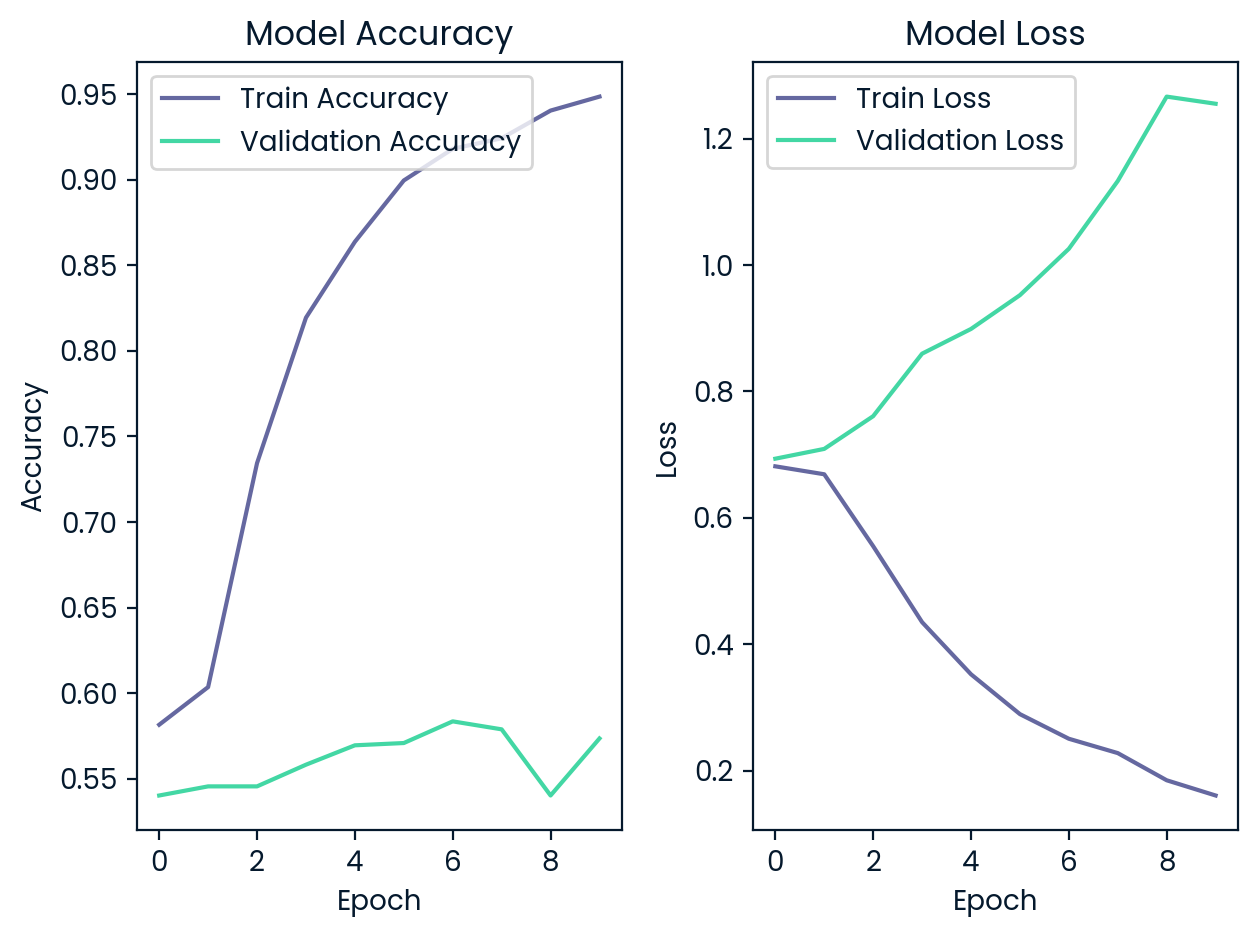

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


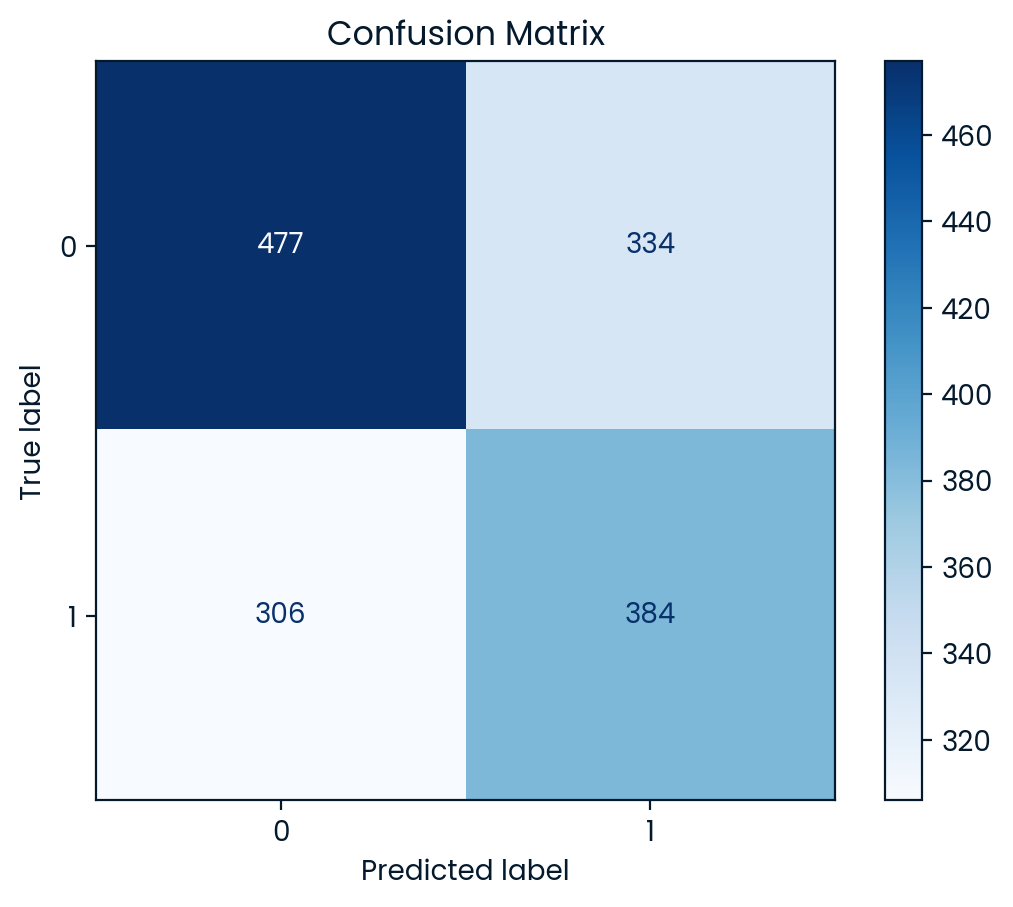

F1 Score: 0.5454545454545454


In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Predict the classes for the test set
test_predictions = (model.predict(test_sequences) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate the F1 score
f1 = f1_score(test_labels, test_predictions)
print(f'F1 Score: {f1}')

## Alternative Model
Now, lets try an alternative architecture, using LSTM instead of simple RNN

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5747 - loss: 0.6853 - val_accuracy: 0.5403 - val_loss: 0.6985
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5786 - loss: 0.6812 - val_accuracy: 0.5403 - val_loss: 0.6920
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5892 - loss: 0.6777 - val_accuracy: 0.5403 - val_loss: 0.6929
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5820 - loss: 0.6803 - val_accuracy: 0.5403 - val_loss: 0.6922
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5847 - loss: 0.6795 - val_accuracy: 0.5403 - val_loss: 0.6948
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5791 - loss: 0.6808 - val_accuracy: 0.5403 - val_loss: 0.6922
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5810 - loss: 0.6806 - val_accuracy: 0.5403 - val_loss: 0.6926
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5871 - loss: 0.6784 - val_ac

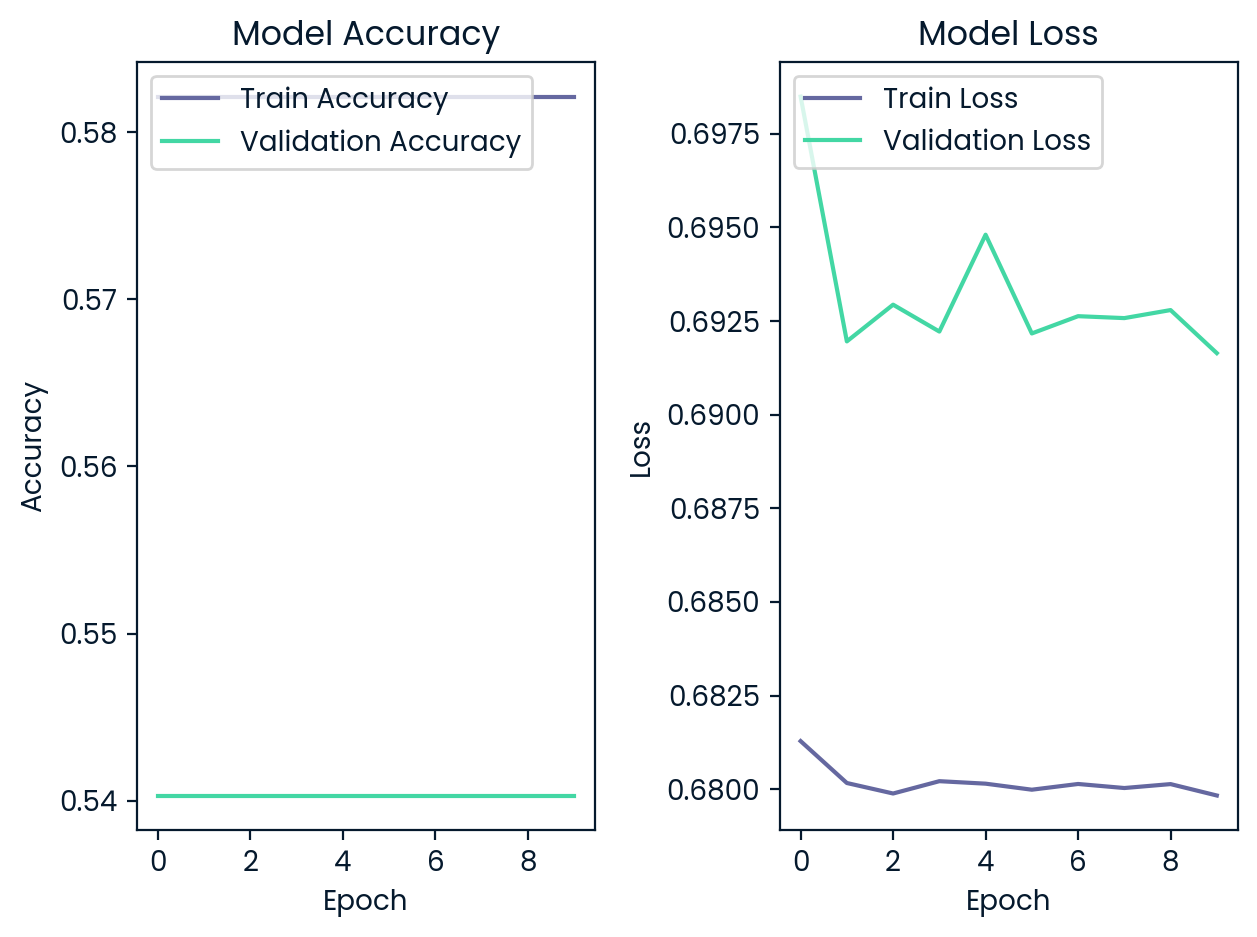

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


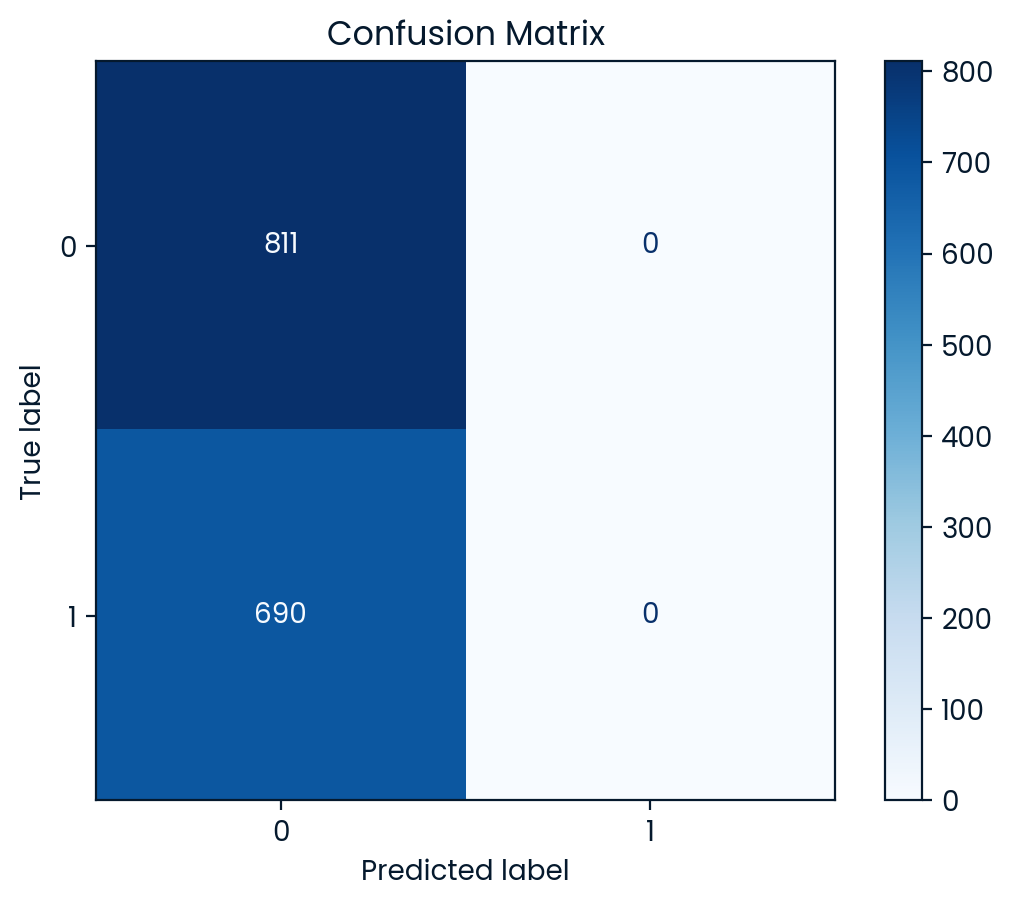

F1 Score: 0.0


In [36]:
from tensorflow.keras.layers import LSTM

# Build the alternative RNN model with an LSTM layer
model_alt2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32),  # LSTM layer with 32 units
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the alternative model
model_alt2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the alternative model and store the history
history_alt = model_alt2.fit(train_sequences, train_labels, epochs=10, validation_data=(test_sequences, test_labels))
# Evaluate the model
loss, accuracy = model_alt2.evaluate(test_sequences, test_labels)
print(f'Test Accuracy: {accuracy}')
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_alt.history['accuracy'], label='Train Accuracy')
plt.plot(history_alt.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_alt.history['loss'], label='Train Loss')
plt.plot(history_alt.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Predict the classes for the test set
test_predictions = (model_alt2.predict(test_sequences) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate the F1 score
f1 = f1_score(test_labels, test_predictions)
print(f'F1 Score: {f1}')

We see clearly that this model was not effective, as it did not predict any class labels as 1.

## Hyperparameter Tuning
Next, let's try to use hyperparameter tuning to see if we can optimize the first model. We'll try different values for the number of units in the SimpleRNN layer, the embedding dimension, and the number of epochs.

In [37]:
embedding_dims = [16, 32]  # Different embedding dimensions to try
rnn_units = [32, 64]  # Different number of units in the SimpleRNN layer to try
# Function to build and compile the model
def build_model(embedding_dim, rnn_units):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SimpleRNN(rnn_units),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Grid search for hyperparameter tuning
best_accuracy = 0
best_params = {}
for embedding_dim in embedding_dims:
    for rnn_unit in rnn_units:
            print(f"Training model with embedding_dim={embedding_dim}, rnn_units={rnn_unit}")
            
            # Build and compile the model
            model = build_model(embedding_dim, rnn_unit)
            
            # Train the model
            history = model.fit(train_sequences, train_labels, epochs=10, validation_data=(test_sequences, test_labels), verbose=0)
            
            # Evaluate the model
            loss, accuracy = model.evaluate(test_sequences, test_labels, verbose=0)
            print(f"Test Accuracy: {accuracy}")
            
            # Check if this is the best model so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'embedding_dim': embedding_dim,
                    'rnn_units': rnn_unit,
                }

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")



Training model with embedding_dim=16, rnn_units=32
Test Accuracy: 0.6955363154411316
Training model with embedding_dim=16, rnn_units=64
Test Accuracy: 0.6682211756706238
Training model with embedding_dim=32, rnn_units=32
Test Accuracy: 0.5596269369125366
Training model with embedding_dim=32, rnn_units=64
Test Accuracy: 0.5796135663986206
Best Accuracy: 0.6955363154411316
Best Parameters: {'embedding_dim': 16, 'rnn_units': 32}


We see that the best parameters are Best Parameters: {'embedding_dim': 16, 'rnn_units': 32}. Now that we have the best parameters, we will evaluate the model more fully before using it on the test data

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5915 - loss: 0.6743 - val_accuracy: 0.7122 - val_loss: 0.5882
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7656 - loss: 0.5271 - val_accuracy: 0.7288 - val_loss: 0.5823
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8502 - loss: 0.3894 - val_accuracy: 0.7442 - val_loss: 0.5774
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8981 - loss: 0.2929 - val_accuracy: 0.7342 - val_loss: 0.6150
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9164 - loss: 0.2535 - val_accuracy: 0.7035 - val_loss: 0.6608
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9392 - loss: 0.1888 - val_accuracy: 0.7202 - val_loss: 0.7266
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9462 - loss: 0.1608 - val_accuracy: 0.7222 - val_loss: 0.7238
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9442 - loss: 0.1628 - val_accu

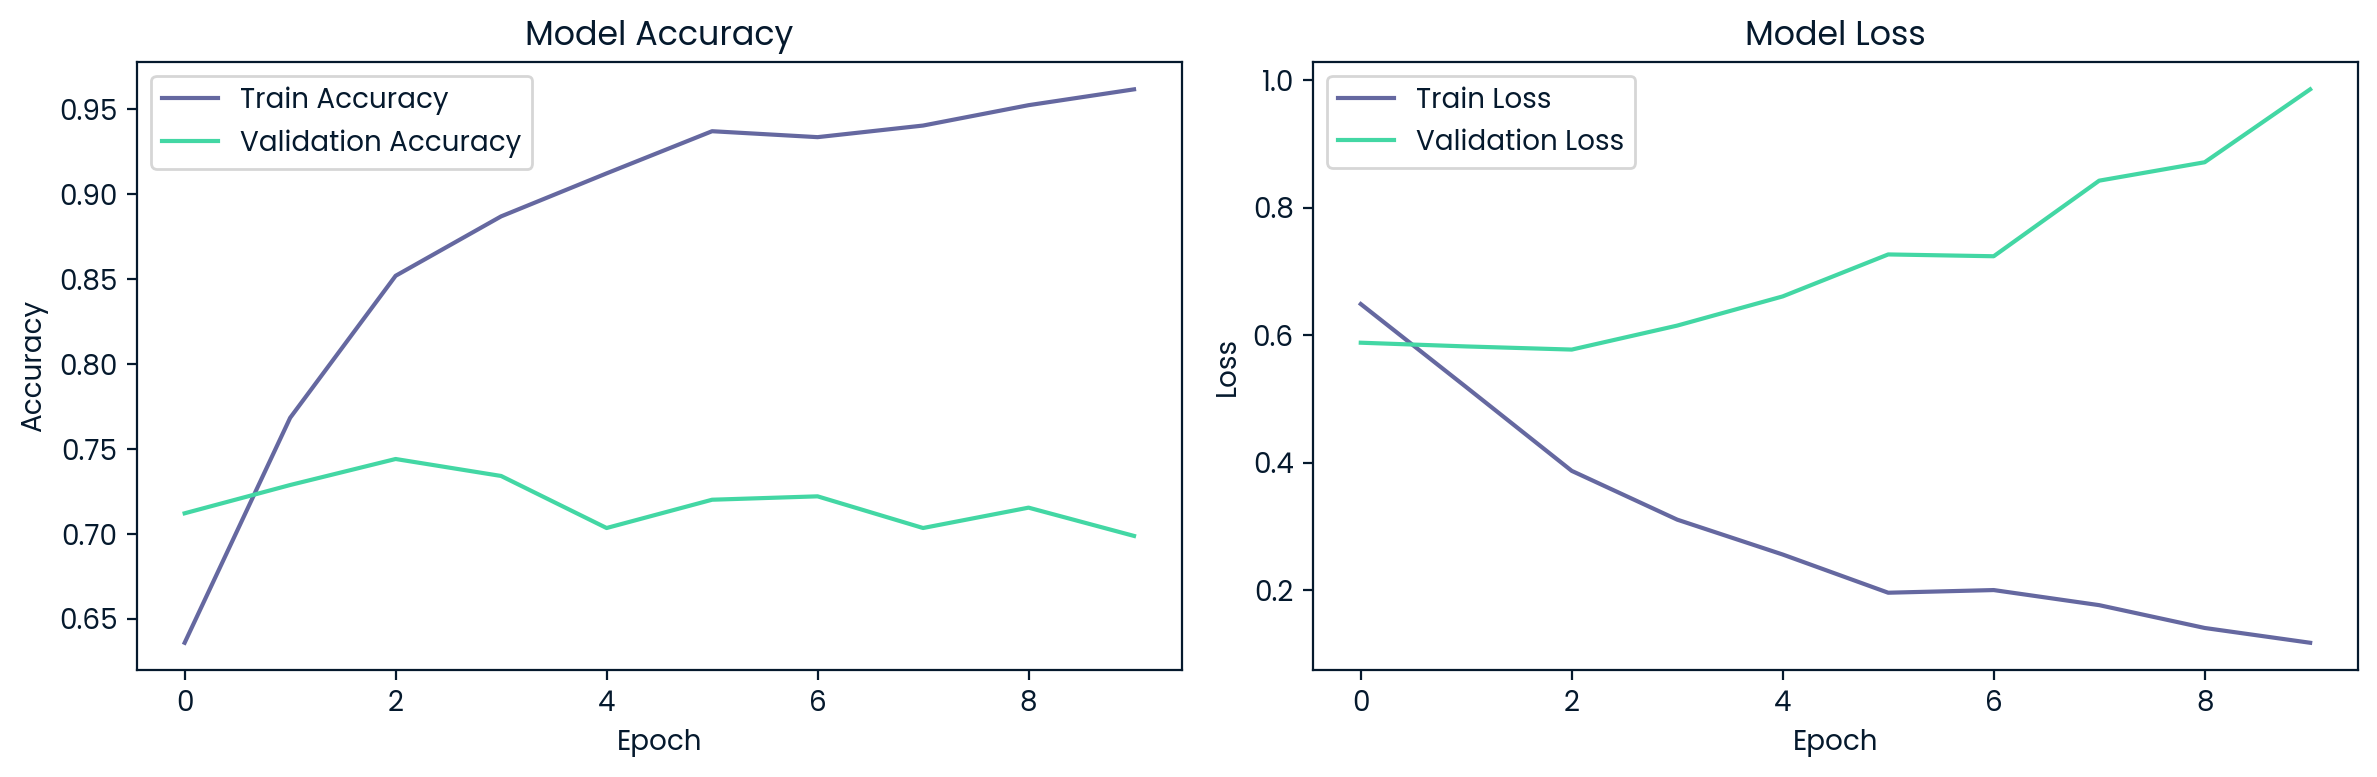

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


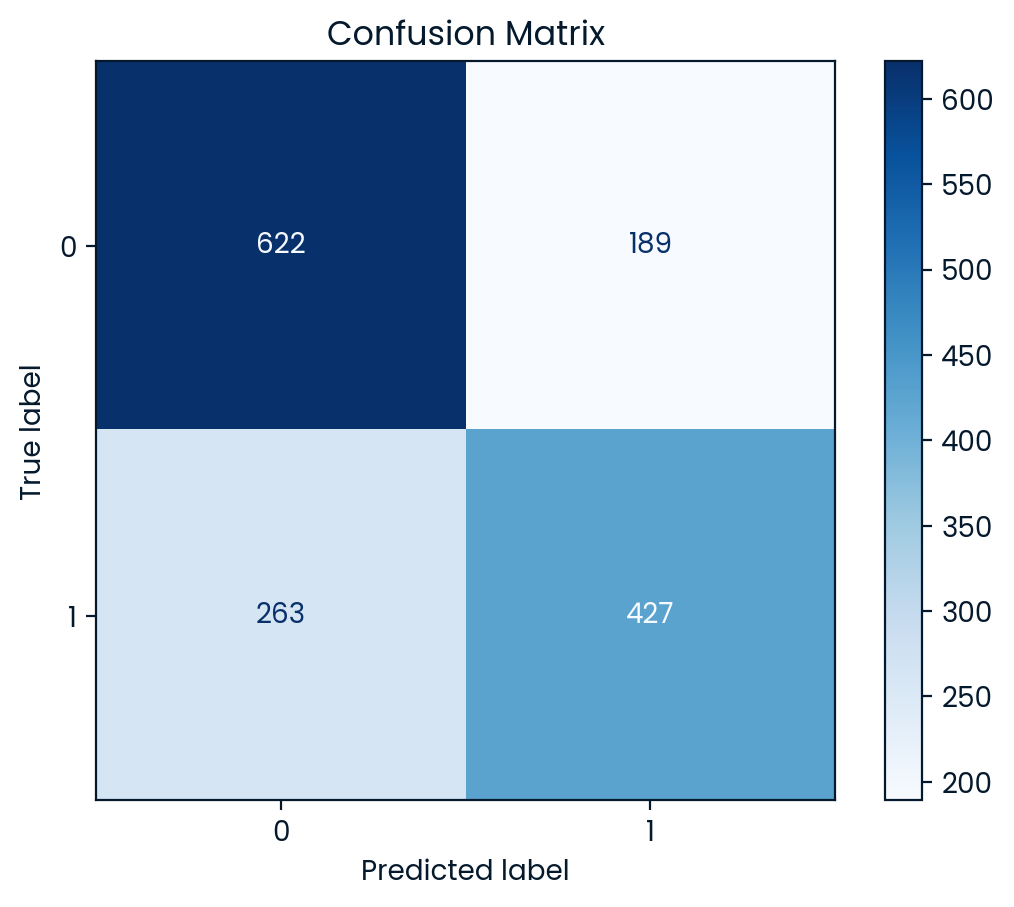

F1 Score: 0.6539050535987749


In [38]:
# Train the best model with the best parameters
best_model = build_model(best_params['embedding_dim'], best_params['rnn_units'])
history = best_model.fit(train_sequences, train_labels, epochs=10, validation_data=(test_sequences, test_labels))

# Evaluate the best model
loss, accuracy = best_model.evaluate(test_sequences, test_labels)
print(f"Best Model Test Accuracy: {accuracy}")

# Plot loss and accuracy as a function of epoch for the best model
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Predict the classes for the test set
test_predictions = (best_model.predict(test_sequences) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate the F1 score
f1 = f1_score(test_labels, test_predictions)
print(f'F1 Score: {f1}')

In [41]:

# Tokenize and pad sequences for the test subset
test_sequences = tokenizer.texts_to_sequences(df_test_subset['text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Get the predictions
predictions = model.predict(test_padded_sequences)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary classes

# Add the predictions to the DataFrame
df_test_subset['predicted_label'] = predicted_classes

# Print the DataFrame with the predictions
display(df_test_subset.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,text,predicted_label
0,happened terrible car crash,0
1,"Heard # earthquake different cities , stay saf...",0
2,"forest fire spot pond , geese fleeing across s...",0
3,Apocalypse lighting . # Spokane # wildfires,1
4,Typhoon Soudelor kills 28 China Taiwan,1


In [48]:
# Merge the 'id' column from df_test into df_test_subset
df_test_subset = df_test[['id']].merge(df_test_subset, left_index=True, right_index=True)

# Display the updated DataFrame
display(df_test_subset.head())

,id,text,predicted_label
0,0,happened terrible car crash,0
1,2,"Heard # earthquake different cities , stay saf...",0
2,3,"forest fire spot pond , geese fleeing across s...",0
3,9,Apocalypse lighting . # Spokane # wildfires,1
4,11,Typhoon Soudelor kills 28 China Taiwan,1


In [49]:
df_test_subset.to_csv('submission.csv', index=False)



# Analysis and Conclusion

While the models did perform moderately well, there are many reasons why they could do better. It may be that additional cleaning is required on the data, such as removing emojis, punctuation and splitting words that have apostrophes, like "can't." It also may be that additional hyperparameter tuning would uncover better parameters. Alternatively, it is also possible that a completely different architecture such as BERT would be preferable in this case.  There also may have been a problem of vanishing or exploding gradient. Further iterations of this analysis are needed to explore these possibities further